# Task 3: Helper notebook for loading the data and saving the predictions

In [1]:
import pickle
import gzip
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import elasticdeform#.tf as etf

### Helper functions

In [2]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [3]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

### Load data, make predictions and save prediction in correct format

In [4]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
samples = load_zipped_pickle("sample.pkl")

In [5]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
import shutil

In [62]:
IMG_SIZE = (112, 112)

directory = '/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/AML/task3/images'

In [63]:
from keras.preprocessing.image import ImageDataGenerator

rotation_range = 20
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.2
zoom_range = 0.15
seed = 1
sigma = .5

batch_size = 30

def preprocessing_function(x):
    # x = elasticdeform.deform_random_grid(x, points=6, sigma=sigma, axis=(0, 1))
    x = (x / 255. - 0.5) * 2.
    return x

def preprocessing_function_label(x):
    x = (x/255.).astype(np.bool_).reshape(IMG_SIZE[0], IMG_SIZE[1], 1)
    return x

def obtain_datagenerator(directory, preprocessing_function, batch_size=batch_size, seed=seed, rotation_range=rotation_range, width_shift_range=width_shift_range, height_shift_range=height_shift_range, shear_range=shear_range, zoom_range=zoom_range, IMG_SIZE=IMG_SIZE):

    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=height_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        preprocessing_function=preprocessing_function,
    )

    generator = datagen.flow_from_directory(
        directory,
        target_size=IMG_SIZE,
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode=None,
        seed = seed,
    )

    return generator

def obtain_test_datagenerator(directory, preprocessing_function, IMG_SIZE=IMG_SIZE):

    datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
    )

    generator = datagen.flow_from_directory(
        directory,
        target_size=IMG_SIZE,
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode=None,
        seed = seed,
    )

    return generator


In [64]:
# TRAIN
# IMAGES
train_generator = obtain_datagenerator(directory + '/train/train', preprocessing_function)

# LABELS
train_mask_generator = obtain_datagenerator(directory + '/train/train_label', preprocessing_function_label)

# BOXES
train_box_generator = obtain_datagenerator(directory + '/train/train_box', preprocessing_function_label)

# VAL
# IMAGES
val_generator = obtain_datagenerator(directory + '/val/train', preprocessing_function)

# LABELS
val_mask_generator = obtain_datagenerator(directory + '/val/train_label', preprocessing_function_label)

# BOXES
val_box_generator = obtain_datagenerator(directory + '/val/train_box', preprocessing_function_label)

# TEST
# IMAGES
test_generator = obtain_test_datagenerator(directory + '/test/train', preprocessing_function)

# LABELS
test_mask_generator = obtain_test_datagenerator(directory + '/test/train_label', preprocessing_function_label)

# BOXES
test_box_generator = obtain_test_datagenerator(directory + '/test/train_box', preprocessing_function_label)

Found 357 images belonging to 1 classes.
Found 357 images belonging to 1 classes.
Found 357 images belonging to 1 classes.
Found 66 images belonging to 1 classes.
Found 66 images belonging to 1 classes.
Found 66 images belonging to 1 classes.
Found 3685 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


In [65]:
# ALL
# IMAGES
all_generator = obtain_test_datagenerator(directory + '/all/train', preprocessing_function)

# LABELS
all_mask_generator = obtain_test_datagenerator(directory + '/all/train_label', preprocessing_function_label)

# # BOXES
# test_box_generator = obtain_test_datagenerator(directory + '/all/train_box', preprocessing_function_label)

Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


In [66]:
def my_image_mask_generator(image_data_generator, mask_data_generator):
    for (img, mask) in zip(image_data_generator, mask_data_generator):
        yield (img, mask)

In [67]:
train_batches = my_image_mask_generator(train_generator, train_mask_generator)

val_batches = my_image_mask_generator(val_generator, val_mask_generator)

all_batches = my_image_mask_generator(all_generator, all_mask_generator)

# MODEL

In [68]:
dropout = .3

In [69]:
def double_conv_block(x, n_filters):

   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "linear", kernel_initializer = "he_normal")(x)
   x = layers.BatchNormalization()(x)
   x = layers.Activation("relu")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [70]:
def downsample_block(x, n_filters):
   
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2, strides=2)(f)
   p = layers.BatchNormalization()(p)
   p = layers.Dropout(dropout)(p)

   return f, p

In [71]:
def upsample_block(x, conv_features, n_filters):
   
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same", activation="linear")(x)
   x = layers.BatchNormalization()(x)
   x = layers.Activation("relu")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(dropout)(x)
   x = double_conv_block(x, n_filters)

   return x

In [72]:
def build_unet_model():
    
    inputs = layers.Input(shape=IMG_SIZE + (1,))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

unet_model = build_unet_model()

In [40]:
dropout = .65

In [55]:
def build_unet_model():
    
    inputs = layers.Input(shape=IMG_SIZE + (1,))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 128)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 512)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 1024)

    # 5 - bottleneck
    bottleneck = double_conv_block(p3, 2048)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f3, 1024)
    # 7 - upsample
    u7 = upsample_block(u6, f2, 512)
    # 8 - upsample
    u8 = upsample_block(u7, f1, 128)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u8)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

unet_model = build_unet_model()

In [56]:
print(unet_model.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 856, 856, 1)]        0         []                            
                                                                                                  
 conv2d_104 (Conv2D)         (None, 856, 856, 128)        1280      ['input_8[0][0]']             
                                                                                                  
 batch_normalization_96 (Ba  (None, 856, 856, 128)        512       ['conv2d_104[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_69 (Activation)  (None, 856, 856, 128)        0         ['batch_normalization_96[0

In [93]:
unet_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])#, keras.metrics.MeanIoU(num_classes=2)])

In [94]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(seed)

In [95]:
def scheduler(epoch, lr):
    if epoch == 30:
        return lr / 10
    else:
        return lr

callback = keras.callbacks.LearningRateScheduler(scheduler)

In [96]:
NUM_EPOCHS = 45

STEPS_PER_EPOCH = (165 // batch_size) * 5
VALIDATION_STEPS = 1

model_history = unet_model.fit(all_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              callbacks=[callback],
                              validation_data=val_batches)

Epoch 1/45
25/25 [==============================] - 50s 2s/step - loss: 0.0728 - accuracy: 0.9736 - val_loss: 1.4651 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 2/45
25/25 [==============================] - 46s 2s/step - loss: 0.0271 - accuracy: 0.9911 - val_loss: 0.4727 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 3/45
25/25 [==============================] - 46s 2s/step - loss: 0.0190 - accuracy: 0.9915 - val_loss: 0.1065 - val_accuracy: 0.9866 - lr: 0.0010
Epoch 4/45
25/25 [==============================] - 44s 2s/step - loss: 0.0164 - accuracy: 0.9927 - val_loss: 0.1253 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 5/45
25/25 [==============================] - 46s 2s/step - loss: 0.0138 - accuracy: 0.9943 - val_loss: 0.0892 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 6/45
25/25 [==============================] - 46s 2s/step - loss: 0.0128 - accuracy: 0.9948 - val_loss: 0.1678 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 7/45
25/25 [==============================] - 45s 2s/step - loss: 0.0118 - a

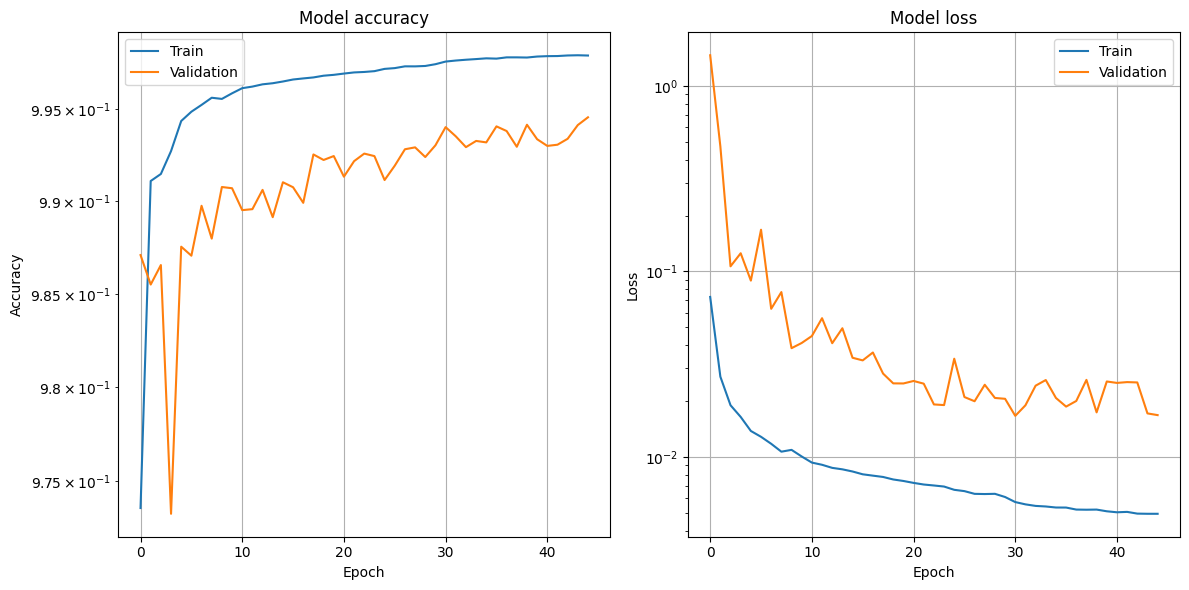

In [98]:
# big one, with all data

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.yscale('log')
plt.grid()
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.yscale('log')
plt.grid()
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

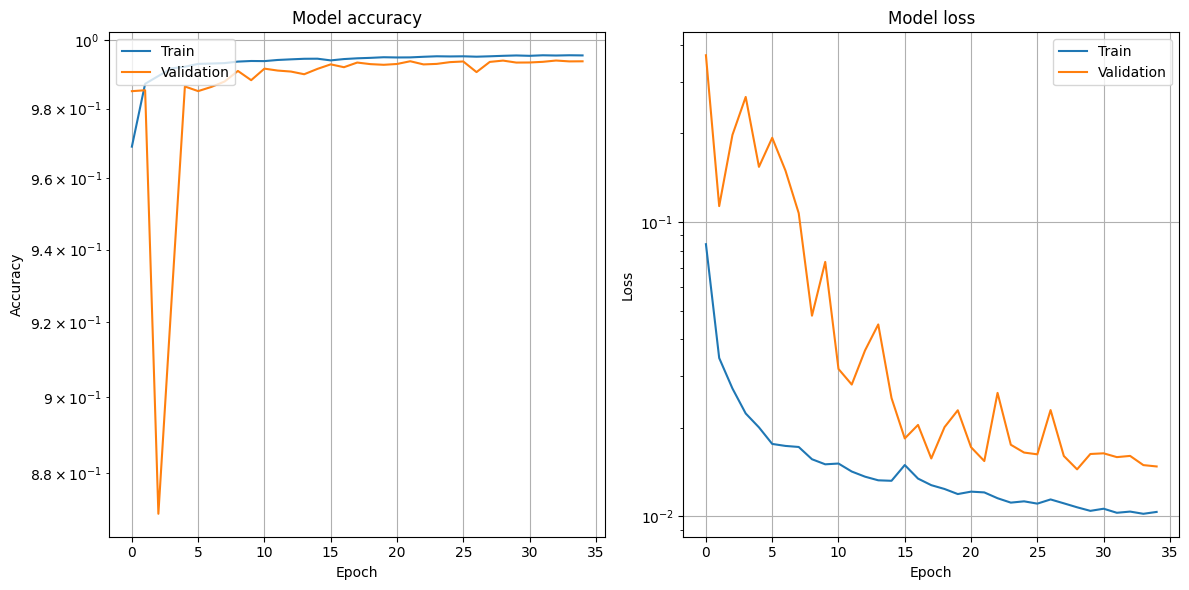

In [59]:
# big one, with only train, not all

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.yscale('log')
plt.grid()
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.yscale('log')
plt.grid()
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

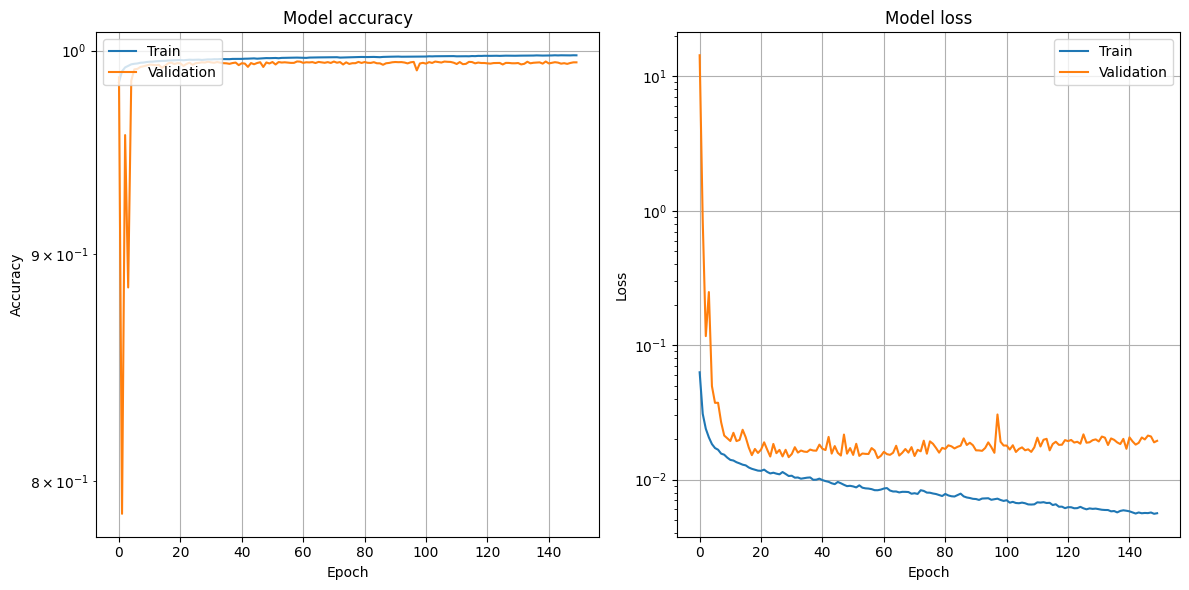

In [49]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.yscale('log')
plt.grid()
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.yscale('log')
plt.grid()
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
def build_unet_model():
    
    inputs = layers.Input(shape=IMG_SIZE + (1,))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)

    # 5 - bottleneck
    bottleneck = double_conv_block(p3, 512)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f3, 256)
    # 7 - upsample
    u7 = upsample_block(u6, f2, 128)
    # 8 - upsample
    u8 = upsample_block(u7, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u8)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

unet_model = build_unet_model()

In [20]:
NUM_EPOCHS = 150

STEPS_PER_EPOCH = (165 // batch_size) * 5
VALIDATION_STEPS = 1

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                            #   callbacks=[callback],
                              validation_data=val_batches)

Epoch 1/150


2023-12-15 09:12:26.902521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 11s 256ms/step - loss: 0.1185 - accuracy: 0.9545 - val_loss: 0.6844 - val_accuracy: 0.9849
Epoch 2/150
25/25 [==============================] - 5s 186ms/step - loss: 0.0300 - accuracy: 0.9875 - val_loss: 0.1354 - val_accuracy: 0.9854
Epoch 3/150
25/25 [==============================] - 5s 185ms/step - loss: 0.0214 - accuracy: 0.9913 - val_loss: 0.1317 - val_accuracy: 0.9252
Epoch 4/150
25/25 [==============================] - 5s 190ms/step - loss: 0.0184 - accuracy: 0.9927 - val_loss: 0.1296 - val_accuracy: 0.9301
Epoch 5/150
25/25 [==============================] - 5s 187ms/step - loss: 0.0163 - accuracy: 0.9935 - val_loss: 0.0518 - val_accuracy: 0.9743
Epoch 6/150
25/25 [==============================] - 5s 185ms/step - loss: 0.0149 - accuracy: 0.9940 - val_loss: 0.0230 - val_accuracy: 0.9908
Epoch 7/150
25/25 [==============================] - 5s 191ms/step - loss: 0.0143 - accuracy: 0.9942 - val_loss: 0.0233 - val_accuracy: 0.9919
Epoch 8/15

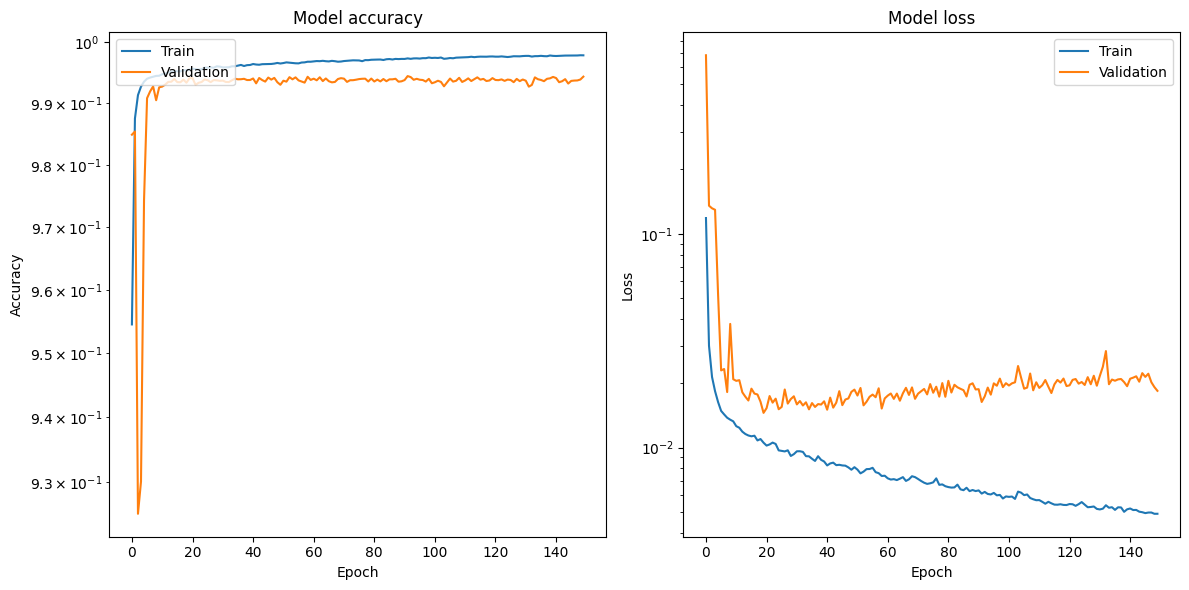

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.yscale('log')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.yscale('log')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [285]:
NUM_EPOCHS = 50

STEPS_PER_EPOCH = (165 // batch_size) * 5
VALIDATION_STEPS = 1

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              callbacks=[callback],
                              validation_data=val_batches)

Epoch 1/50
15/15 [==============================] - 22s 1s/step - loss: 0.1059 - accuracy: 0.9616 - val_loss: 1587.7875 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 19s 1s/step - loss: 0.0367 - accuracy: 0.9871 - val_loss: 22.1768 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 19s 1s/step - loss: 0.0246 - accuracy: 0.9872 - val_loss: 1.1179 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 18s 1s/step - loss: 0.0220 - accuracy: 0.9876 - val_loss: 0.1477 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 19s 1s/step - loss: 0.0202 - accuracy: 0.9902 - val_loss: 0.0979 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 18s 1s/step - loss: 0.0173 - accuracy: 0.9931 - val_loss: 0.1023 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 7/50
15/15 [==============================] - 18s 1s/step - loss: 0.0154

In [29]:
def build_unet_model():
    
    inputs = layers.Input(shape=IMG_SIZE + (1,))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)

    # 5 - bottleneck
    bottleneck = double_conv_block(p2, 512)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f2, 256)
    # 8 - upsample
    u8 = upsample_block(u6, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u8)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

unet_model = build_unet_model()

In [30]:
print(unet_model.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 112, 112, 1)]        0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 112, 112, 64)         640       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_22 (Ba  (None, 112, 112, 64)         256       ['conv2d_26[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_17 (Activation)  (None, 112, 112, 64)         0         ['batch_normalization_22[0

In [31]:
unet_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])#, keras.metrics.MeanIoU(num_classes=2)])

In [32]:
NUM_EPOCHS = 150

STEPS_PER_EPOCH = (165 // batch_size) * 5
VALIDATION_STEPS = 1

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                            #   callbacks=[callback],
                              validation_data=val_batches)

Epoch 1/150
25/25 [==============================] - 7s 265ms/step - loss: 0.0919 - accuracy: 0.9669 - val_loss: 0.4807 - val_accuracy: 0.9862
Epoch 2/150
25/25 [==============================] - 6s 251ms/step - loss: 0.0316 - accuracy: 0.9873 - val_loss: 0.1606 - val_accuracy: 0.9852
Epoch 3/150
25/25 [==============================] - 6s 251ms/step - loss: 0.0234 - accuracy: 0.9907 - val_loss: 0.1304 - val_accuracy: 0.9858
Epoch 4/150
25/25 [==============================] - 6s 251ms/step - loss: 0.0205 - accuracy: 0.9923 - val_loss: 0.0701 - val_accuracy: 0.9859
Epoch 5/150
25/25 [==============================] - 6s 252ms/step - loss: 0.0185 - accuracy: 0.9928 - val_loss: 0.0859 - val_accuracy: 0.9857
Epoch 6/150
25/25 [==============================] - 6s 250ms/step - loss: 0.0164 - accuracy: 0.9935 - val_loss: 0.0663 - val_accuracy: 0.9870
Epoch 7/150
25/25 [==============================] - 6s 249ms/step - loss: 0.0152 - accuracy: 0.9939 - val_loss: 0.0463 - val_accuracy: 0.9889

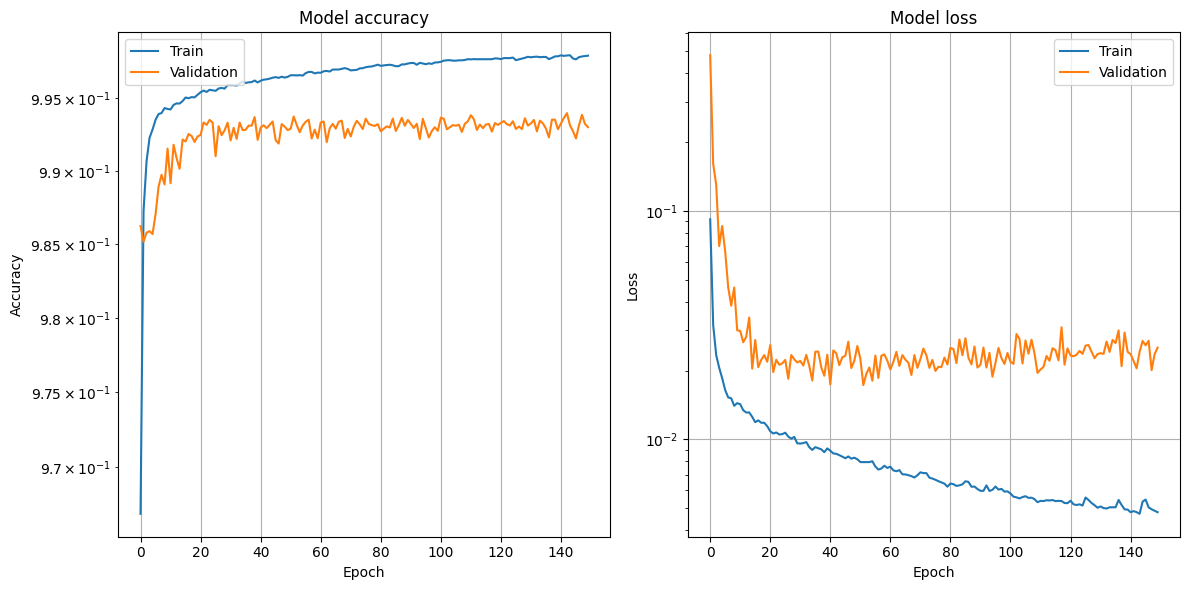

In [34]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.yscale('log')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.yscale('log')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

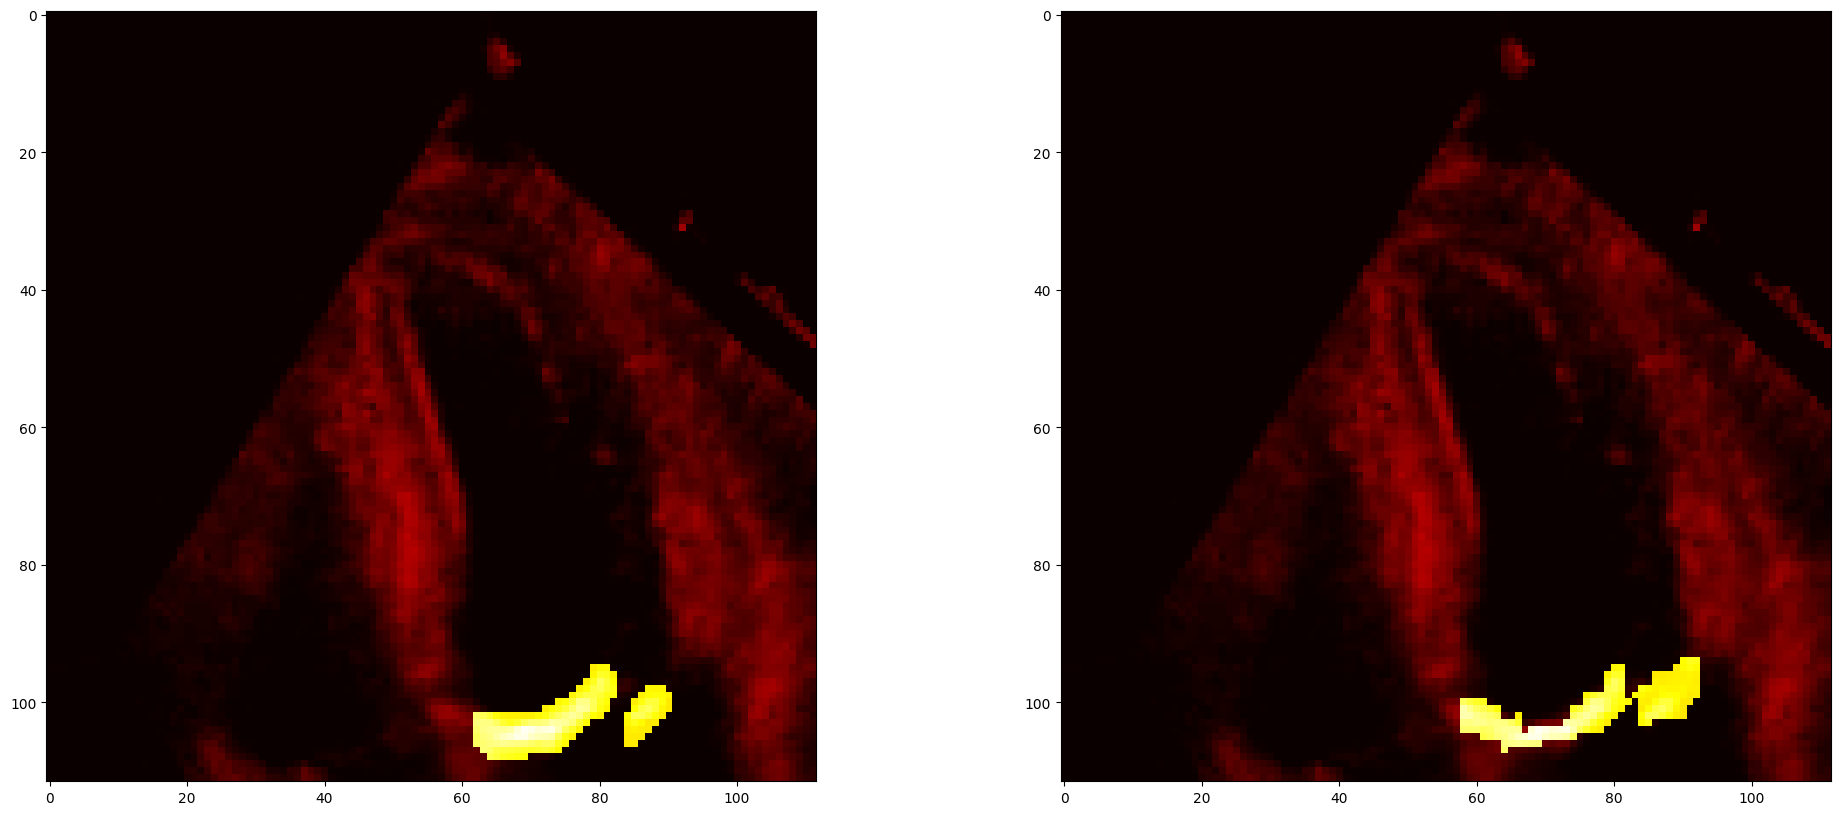

In [36]:
a = next(val_batches)
b = np.where(unet_model.predict(a[0])>0.5, 1, 0)

for i in range(batch_size):
    plt.figure(figsize=(24, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(a[0][i] + 5*b[i], cmap='hot', vmin=-1, vmax=6)
    plt.subplot(1, 2, 2)
    plt.imshow(a[0][i] + 5*a[1][i], cmap='hot', vmin=-1, vmax=6)
    plt.show()
    clear_output(wait=True)
    time.sleep(.5)

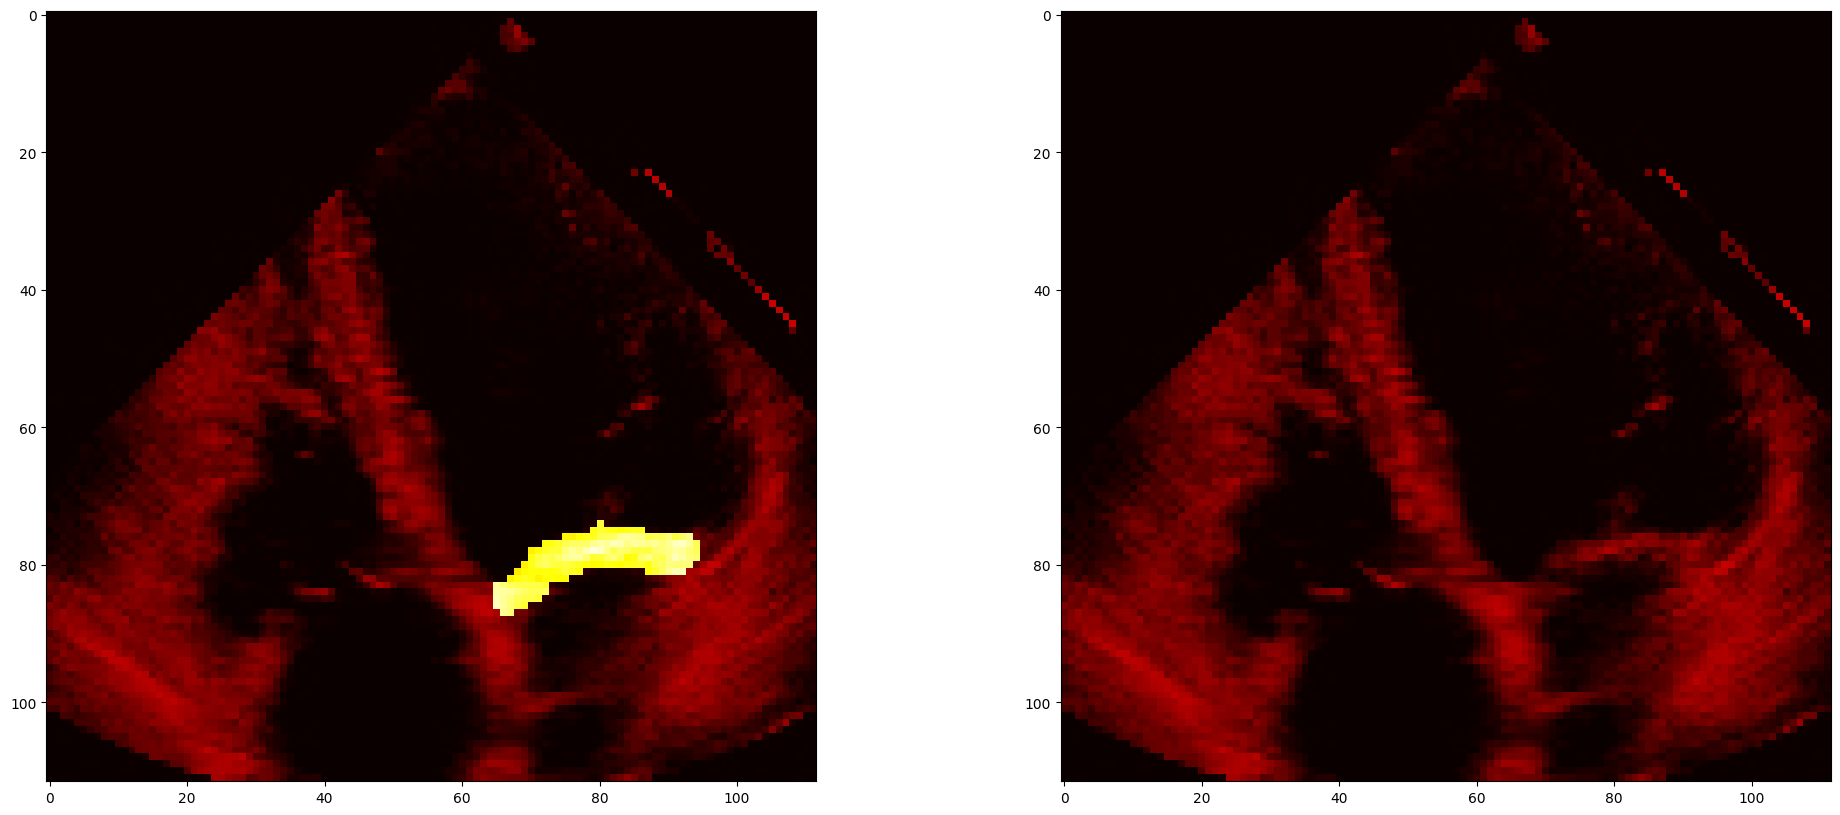

In [346]:
a = next(test_generator)
b = np.where(unet_model.predict(a)>0.5, 1, 0)

for i in range(batch_size):
    plt.figure(figsize=(24, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(a[i] + 5*b[i], cmap='hot', vmin=-1, vmax=6)
    plt.subplot(1, 2, 2)
    plt.imshow(a[i], cmap='hot', vmin=-1, vmax=6)
    plt.show()
    clear_output(wait=True)
    time.sleep(1)

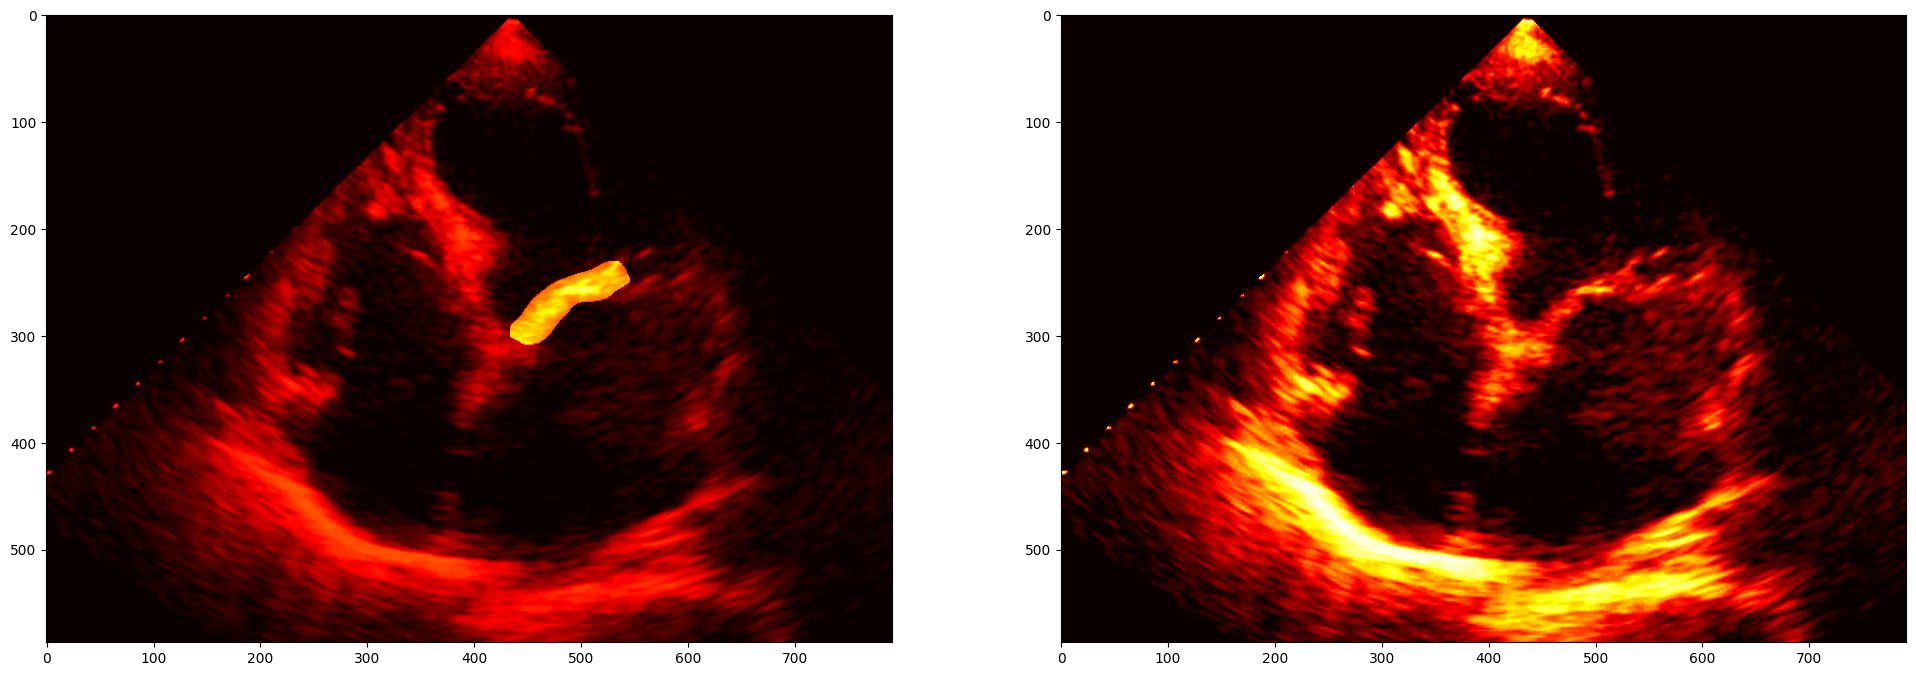

In [63]:
ind = 1

video = test_data[ind]['video']

video_gray = cv2.resize(video, IMG_SIZE, interpolation = cv2.INTER_LANCZOS4).astype(np.uint8)
video_gray = preprocessing_function(video_gray).transpose(2,0,1)
video_gray = video_gray.reshape(*video_gray.shape, 1)

predictions = unet_model.predict(video_gray, verbose=False).transpose(1,2,0,3)[:,:,:,0]
predictions = cv2.resize(predictions, (video.shape[1], video.shape[0]), interpolation = cv2.INTER_LANCZOS4)
predictions = np.where(predictions>.5, True, False)

for i in range(predictions.shape[2]):
    plt.figure(figsize=(24, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(video[:,:,i]/255 + predictions[:,:,i].astype(bool), cmap='hot', vmin=0, vmax=2)
    plt.subplot(1, 2, 2)
    plt.imshow(video[:,:,i]/255, cmap='hot', vmin=0, vmax=1)
    plt.show()
    clear_output(wait=True)
    # time.sleep(.01)

In [99]:
predictions_list = []

for d in test_data:

    video = d['video']

    video_gray = cv2.resize(video, IMG_SIZE, interpolation = cv2.INTER_LANCZOS4).astype(np.uint8)
    video_gray = preprocessing_function(video_gray).transpose(2,0,1)
    video_gray = video_gray.reshape(*video_gray.shape, 1)

    predictions = unet_model.predict(video_gray, verbose=False).transpose(1,2,0,3)[:,:,:,0]
    predictions = cv2.resize(predictions, (video.shape[1], video.shape[0]), interpolation = cv2.INTER_LANCZOS4)
    predictions = np.where(predictions>.5, True, False)

    predictions_list.append({
        'name': d['name'],
        'prediction': predictions
        }
    )

In [100]:
save_zipped_pickle(predictions_list, 'my_predictions.pkl')